In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")

from models import  hierarchical_gnn
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from loader import hetero_graph_loader 
import torch
from torch_geometric.loader import DataLoader, DenseDataLoader
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
from torch_geometric.transforms import RemoveIsolatedNodes

from utils import prep
from explainability import grad_cam
from graph_plotting import graph_2D
from torch_geometric.utils import degree

In [2]:

data_type = "DCP"
octa_dr_dict = {"Healthy": 0, "DM": 0, "PDR": 1, "Early NPDR": 2, "Late NPDR": 2}
label_names = ["Healthy/DM", "PDR", "NPDR"]


vessel_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_vessel_graph"
void_graph_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_void_graph"
hetero_edges_path = f"/media/data/alex_johannes/octa_data/Cairo/{data_type}_heter_edges"
label_file = "/media/data/alex_johannes/octa_data/Cairo/labels.csv"


train_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "train",
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)



test_dataset = hetero_graph_loader.HeteroGraphLoaderTorch(vessel_graph_path,
                                                        void_graph_path,
                                                        hetero_edges_path,
                                                        mode = "test",
                                                        label_file = label_file, 
                                                        line_graph_1 =True, 
                                                        class_dict = octa_dr_dict)


In [3]:
# isolated nodes already removed in loader

# prepare data
prep.hetero_graph_imputation(train_dataset)
prep.hetero_graph_imputation(test_dataset)

prep.add_node_features(train_dataset, ["graph_1", "graph_2"])
prep.add_node_features(test_dataset, ["graph_1", "graph_2"])

prep.add_global_node(train_dataset)
prep.add_global_node(test_dataset)

node_mean_tensors, node_std_tensors = prep.hetero_graph_normalization_params(train_dataset)

# save the normalization parameters
#torch.save(node_mean_tensors, f"../checkpoints/{data_type}_node_mean_tensors_global_node_node_degs.pt")
#torch.save(node_std_tensors, f"../checkpoints/{data_type}_node_std_tensors_global_node_node_degs.pt")

# load the normalization parameters
node_mean_tensors = torch.load(f"../checkpoints/{data_type}_node_mean_tensors_global_node_node_degs.pt")
node_std_tensors = torch.load(f"../checkpoints/{data_type}_node_std_tensors_global_node_node_degs.pt")

prep.hetero_graph_normalization(test_dataset, node_mean_tensors, node_std_tensors)



In [4]:
ids  = list(test_dataset.hetero_graphs.keys())
labels = [data.y[0].cpu().detach().item() for data in test_dataset.hetero_graphs.values()]

In [5]:
model = hierarchical_gnn.DiffPool_GNN(hidden_channels= 32,
                                    out_channels= 3,
                                    num_layers= 2,
                                    dropout = 0,
                                    node_types = ["graph_1", "graph_2"],
                                    max_nodes = 10000
                                    )

/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_loader = DataLoader(test_dataset.to(device), batch_size = 2, shuffle=False) # 

for data in test_loader:
    print(data.x_dict["graph_1"].shape,data.x_dict["graph_2"].shape)
    x = model(data.x_dict, data.edge_index_dict, data.batch_dict, data._slice_dict)
    #print(out.detach().cpu().numpy())

    print(x)

    break
    #break

torch.Size([13394, 17]) torch.Size([3717, 17])
tensor([[-6.2669, 48.8367, 39.0139],
        [ 3.2415,  9.4184, 15.8487]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


In [7]:
torch.autograd.set_detect_anomaly(True)
print(x[0,0].backward())

/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in ScatterAddBackward0. No forward pass information available. Enable detect anomaly during forward pass for more information. (Triggered internally at ../torch/csrc/autograd/python_anomaly_mode.cpp:92.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.LongTensor [17481, 1, 32]] is at version 12; expected version 0 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

In [14]:
print(x)

tensor([[ 0.0928,  3.1431,  2.1267],
        [ 2.3562,  3.4030, -1.9832]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Number of learnable parameters: 204291
Ground Truth Label:[1]
Predicted Label:[1]
0001_OS


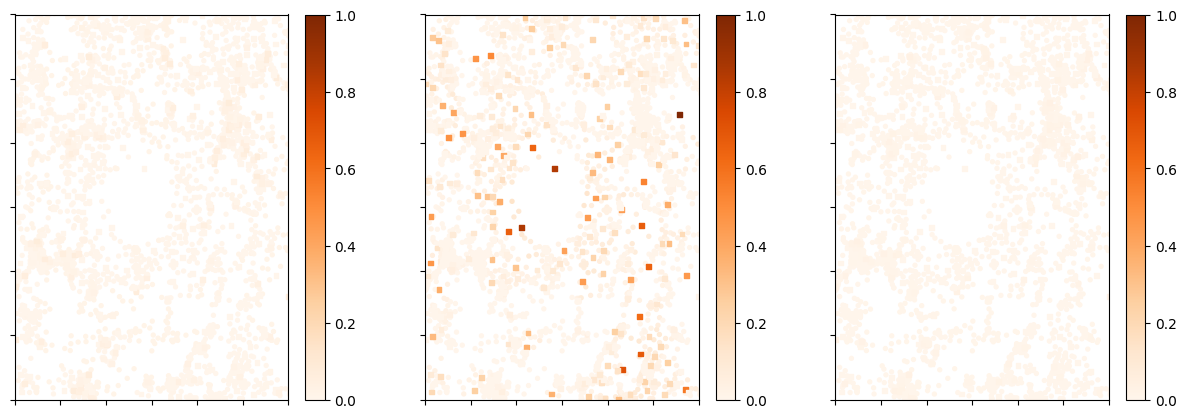

Ground Truth Label:[0]
Predicted Label:[0]
0003_OD


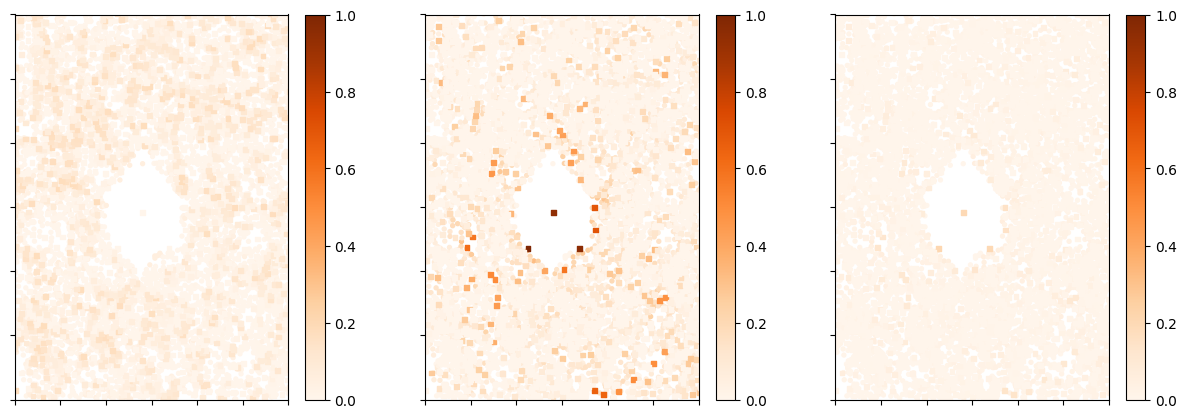

Ground Truth Label:[0]
Predicted Label:[0]
0011_OD


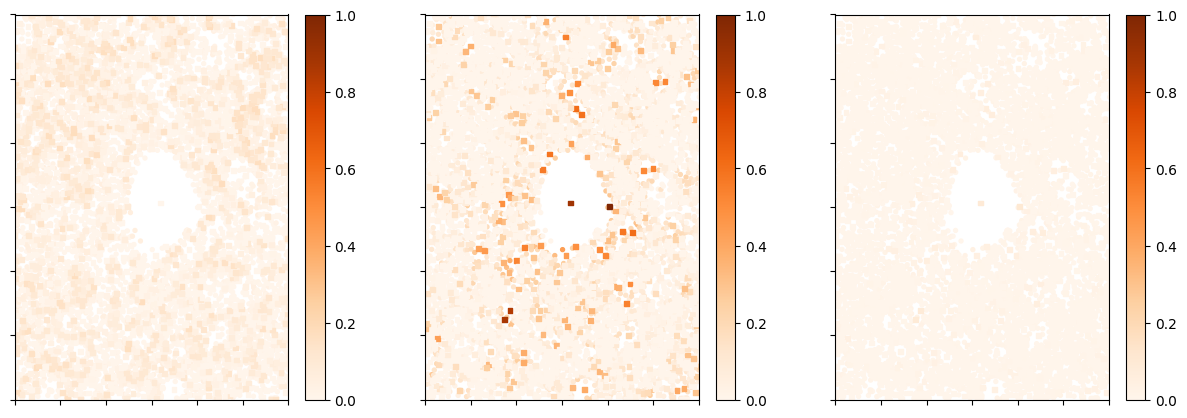

Ground Truth Label:[0]
Predicted Label:[0]
0013_OS


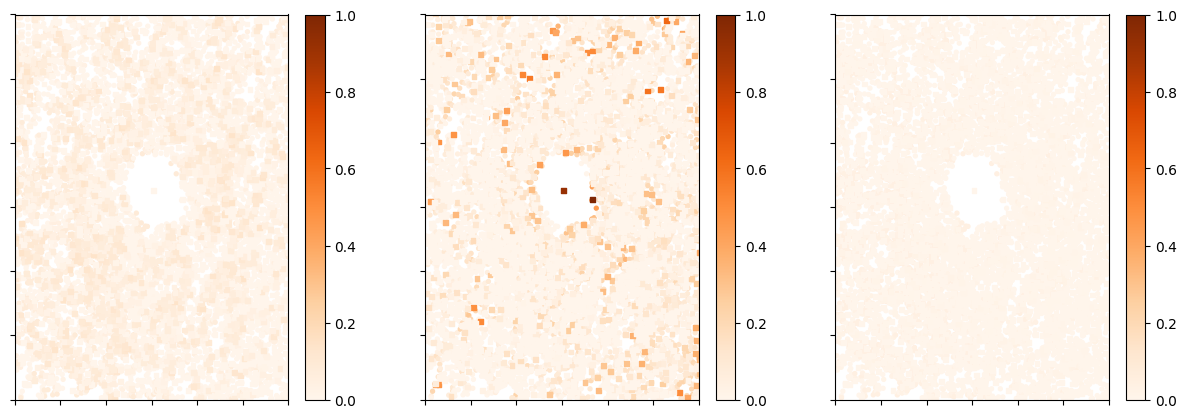

Ground Truth Label:[0]
Predicted Label:[0]
0014_OD


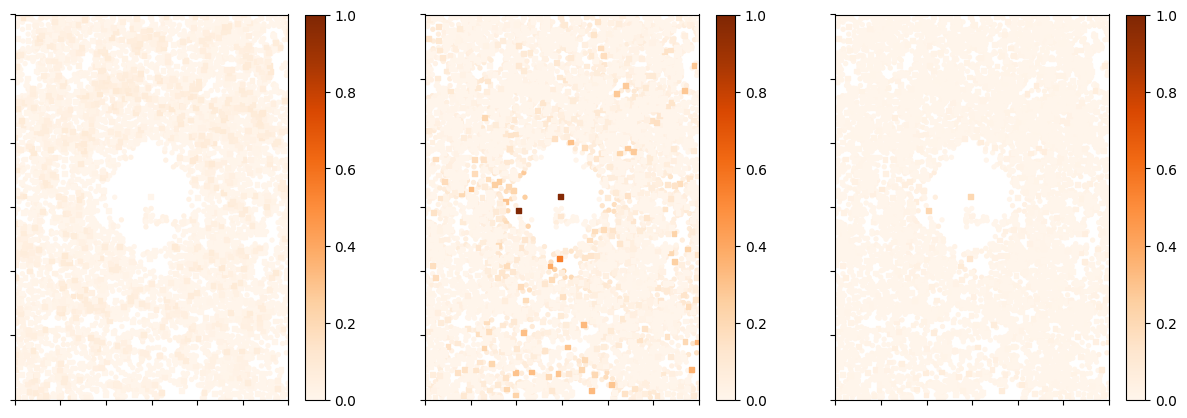

Ground Truth Label:[0]
Predicted Label:[0]
0016_OD


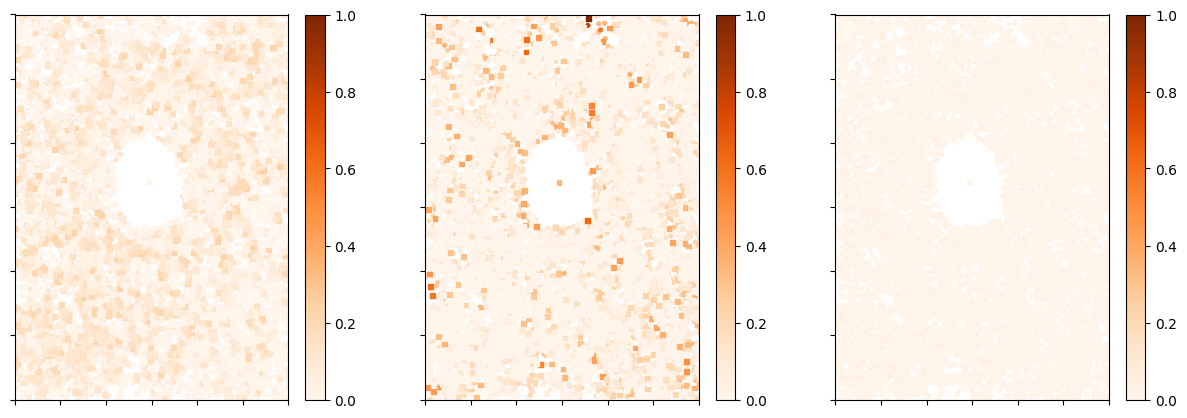

Ground Truth Label:[0]
Predicted Label:[0]
0017_OD


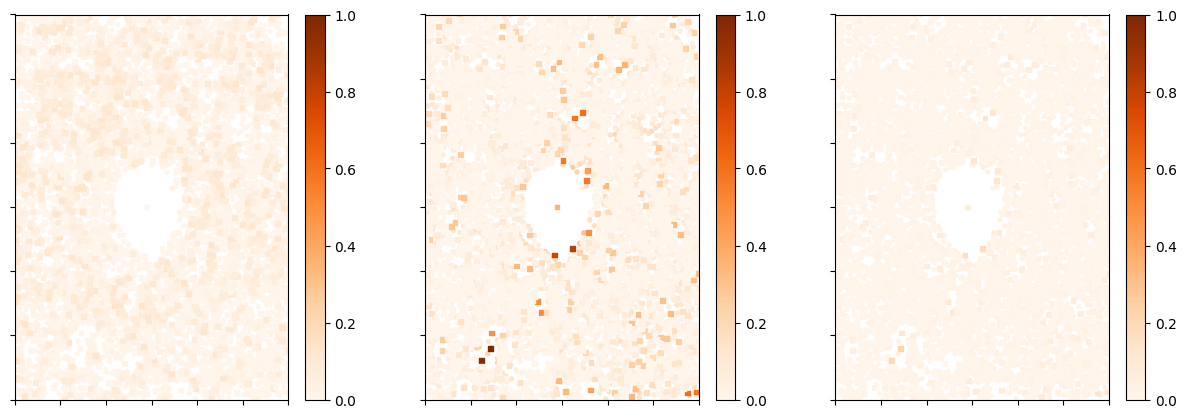

Ground Truth Label:[0]
Predicted Label:[0]
0024_OS


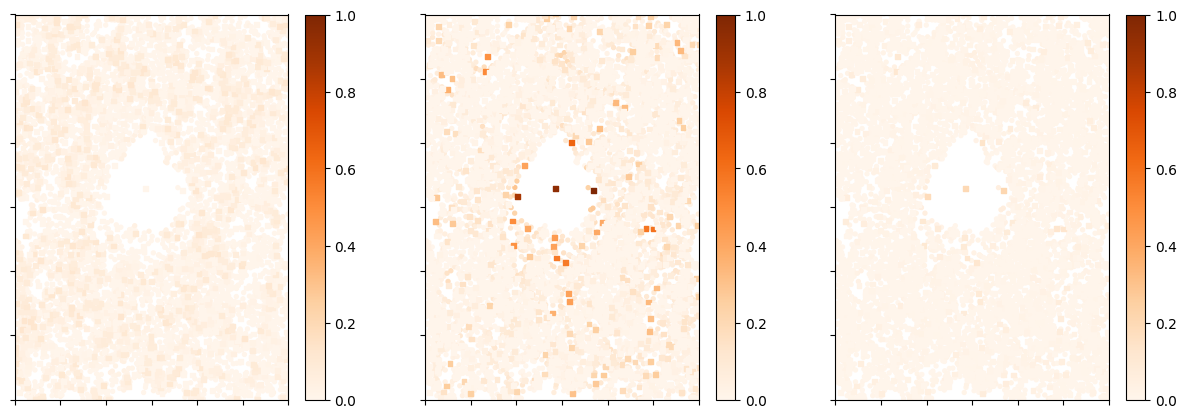

Ground Truth Label:[0]
Predicted Label:[0]
0026_OS


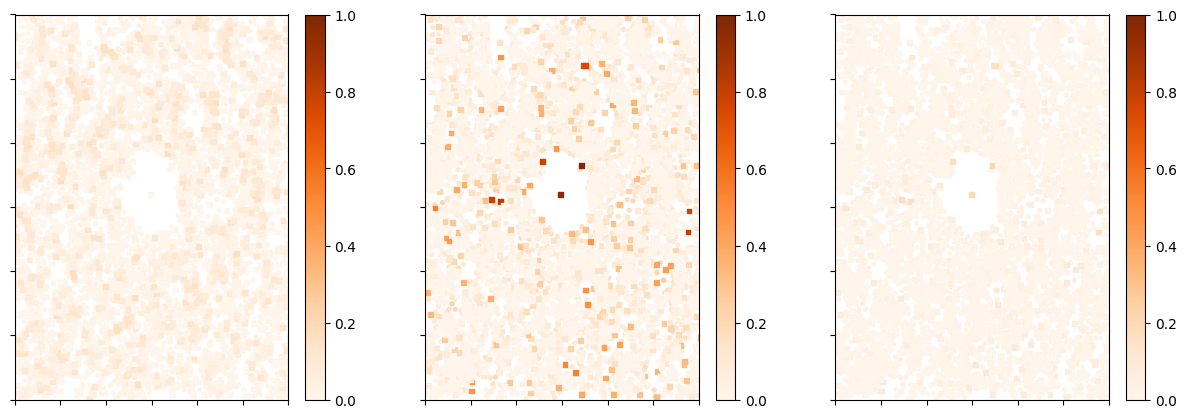

Ground Truth Label:[0]
Predicted Label:[0]
0027_OS


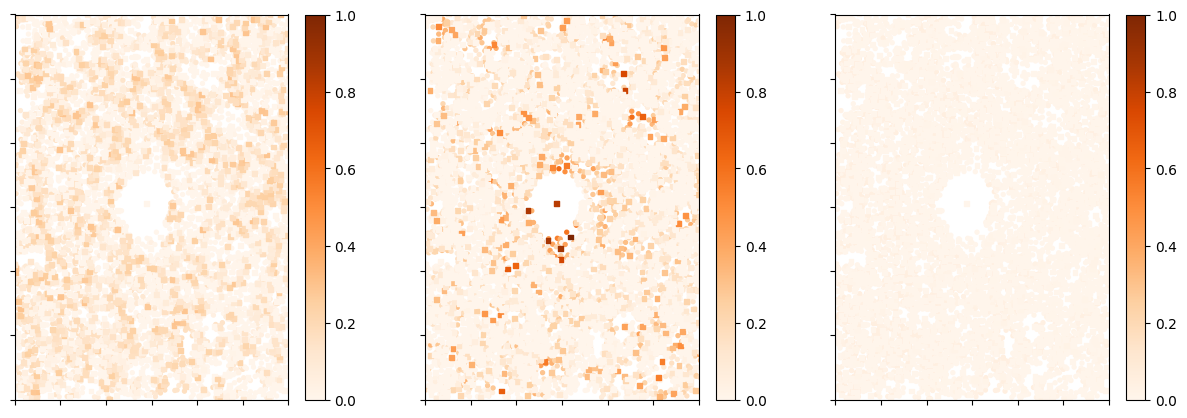

Ground Truth Label:[0]
Predicted Label:[0]
0035_OS


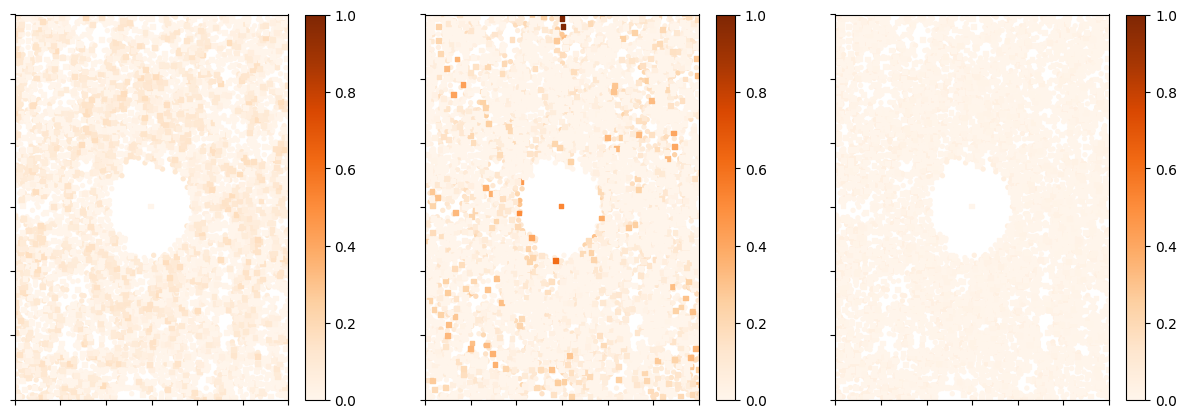

Ground Truth Label:[0]
Predicted Label:[0]
0038_OD


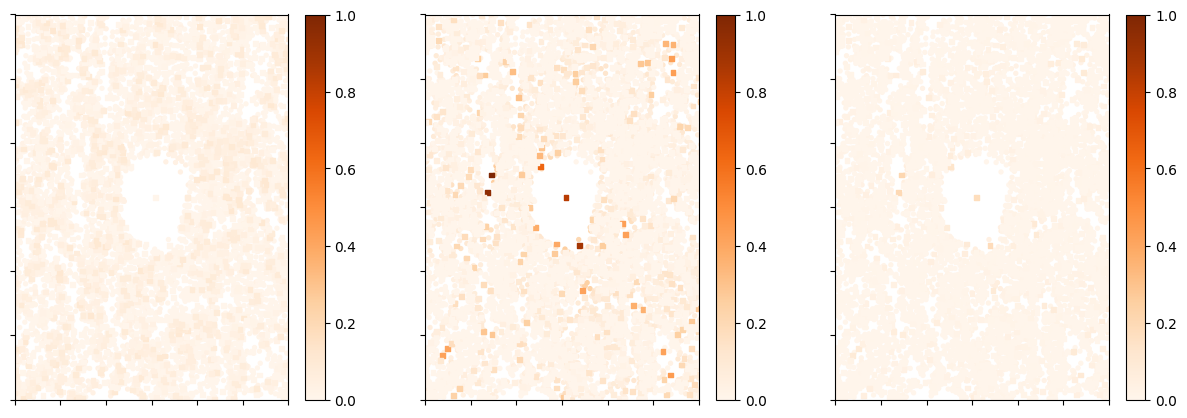

Ground Truth Label:[0]
Predicted Label:[0]
0039_OD


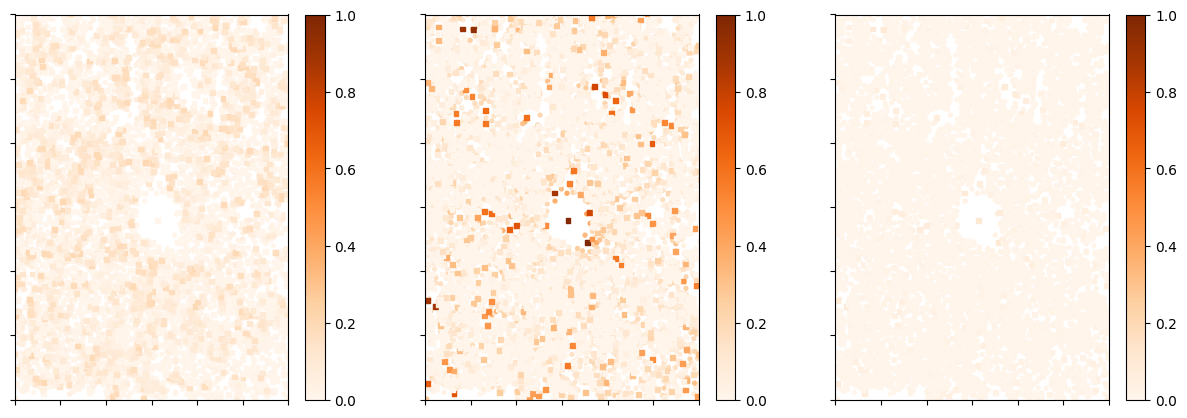

Ground Truth Label:[2]
Predicted Label:[2]


/home/alex_johannes/octa_gnn/OCTA_gnn/notebooks/../explainability/grad_cam.py:82: RuntimeWarning: invalid value encountered in multiply
  scaler.min_ = np.array([-min_scale * scaler.scale_])
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:522: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:522: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:522: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:522: RuntimeWarning: invalid value encountered in multiply
  X *= self.scale_
/home/alex_johannes/octa_gnn/OCTA_gnn/.venv/lib/python3.10/site-packages/sklearn/

0040_OS


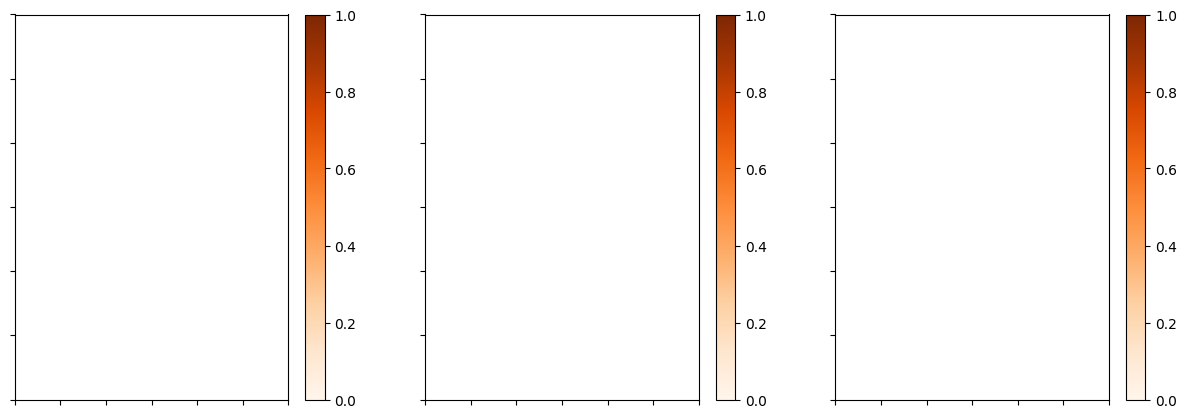

Ground Truth Label:[0]
Predicted Label:[0]
0043_OS


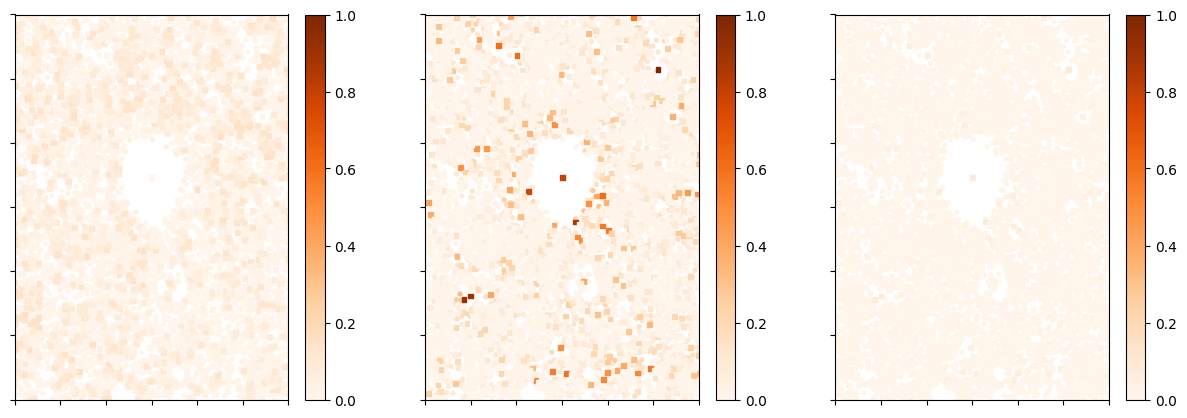

Ground Truth Label:[0]
Predicted Label:[0]
0047_OD


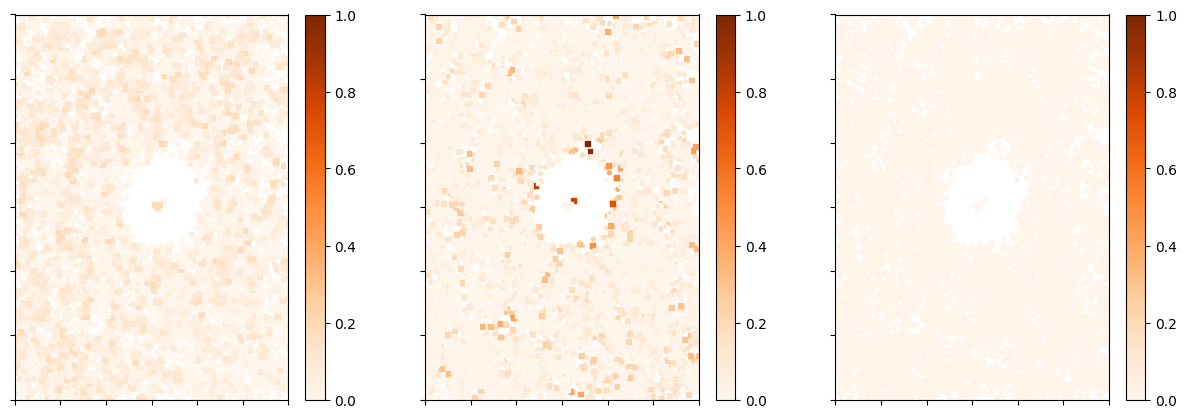

Ground Truth Label:[2]
Predicted Label:[1]
0051_OD


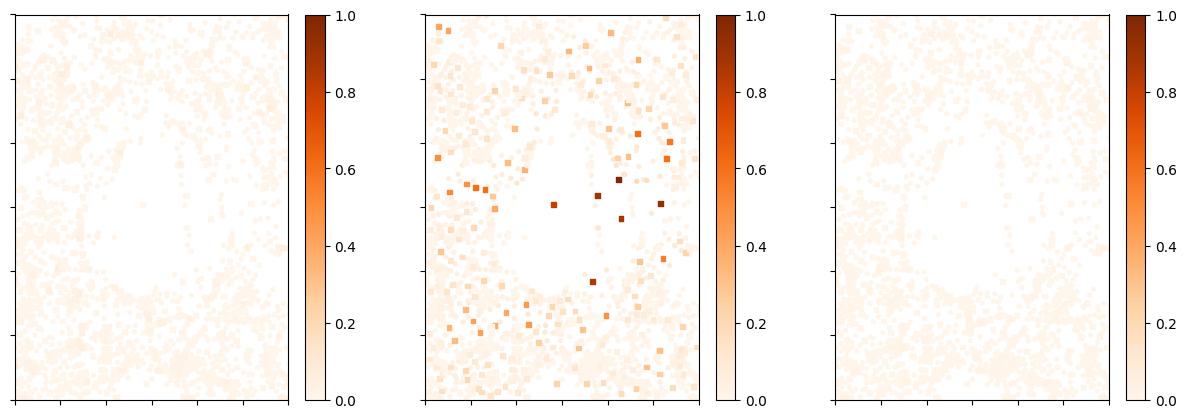

Ground Truth Label:[2]
Predicted Label:[0]
0061_OS


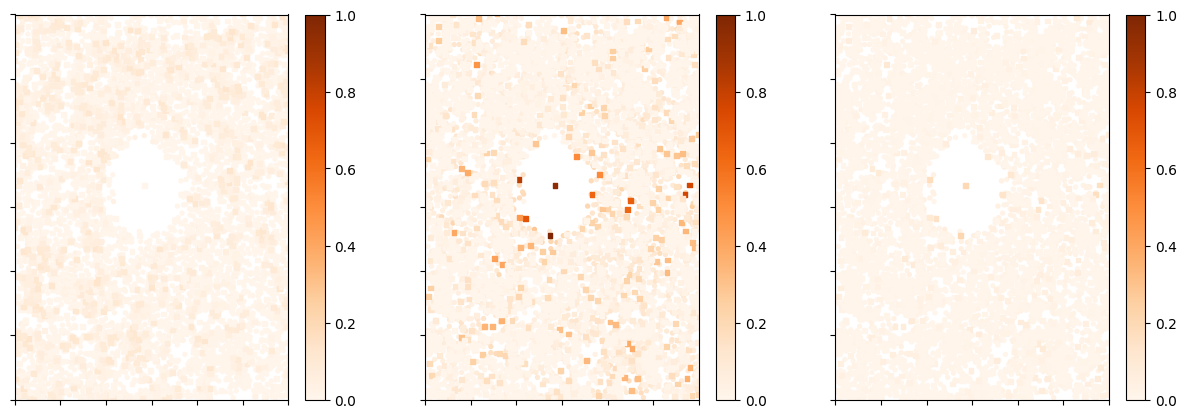

Ground Truth Label:[0]
Predicted Label:[0]
0072_OS


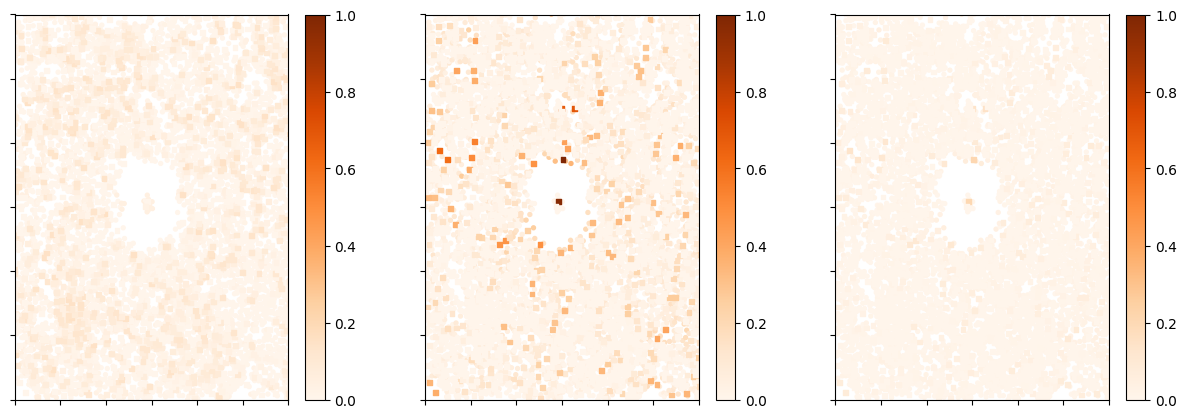

Ground Truth Label:[0]
Predicted Label:[0]


KeyboardInterrupt: 

In [8]:
node_types = ["graph_1", "graph_2"]
# create the gnn hetero model
#model = gnn_models.HeteroGNN(hidden_channels = 64, 
#                              out_channels= 3, 
#                              num_layers= 3, 
#                              dropout = 0, 
#                              aggregation_mode= global_mean_pool,
#                              node_types = node_types,
#                              )

model = gnn_models.HeteroGNN(hidden_channels = 128, 
                              out_channels= 3, 
                              num_layers= 1, 
                              dropout = 0, 
                              aggregation_mode= global_mean_pool,
                              node_types = node_types,
                              )


#load the pretrained weights from the checkpoint "model_global_mean_pool.pt"
state_dict = torch.load("../model_global_mean_pool_best_auc.pt")

#print(state_dict)
model.load_state_dict(state_dict)
print(f"Number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


i = 0
stp = 20

test_loader = DataLoader(test_dataset[:stp], batch_size = 1, shuffle=False) # 

model.to(device)
for data in test_loader:
    model.eval()
    data = data.to(device)
    out = model(data.x_dict, data.edge_index_dict, data.batch_dict, data._slice_dict)
    y_t = data.y.cpu().detach().numpy()
    y_pred = out.cpu().detach().numpy().argmax(axis=1)
    print(f"Ground Truth Label:{y_t}")
    print(f"Predicted Label:{y_pred}")
    #print(accuracy_score(y_t, y_pred))
    #print(balanced_accuracy_score(y_t, y_pred))

    cam_cls = [0,1,2]
    cam = grad_cam.grad_cam_data(model, data, cam_cls, scale = True, relu = True)

    #print(max_val, min_val)
    fig, ax = plt.subplots(1,3, figsize=(15,5))

    print(ids[i])
    for ax_idx, cam_cls in enumerate(cam):
        plotter2d = graph_2D.HeteroGraphPlotter2D()
        plotter2d.set_val_range(1, 0)
        plotter2d.plot_graph_2D(test_dataset[i],edges= False, pred_val_dict=cam_cls, ax = ax[ax_idx])


    plt.show()
    i += 1
    if i >= stp:
        break


In [14]:
data.edge_index_dict[('graph_1',
  'to',
  'graph_2')][0,:]

tensor([4700, 2632, 2762,  ..., 4609, 2160,  721], device='cuda:0')

In [39]:
test_loader = DataLoader(test_dataset[:2], batch_size = 1, shuffle=False) # 

for data in test_loader:
    model.eval()
    data.to(device)
    output = model(data.x_dict, data.edge_index_dict, data.batch_dict, data._slice_dict, training = True, grads = True)
    output[:, 0].backward(retain_graph=True)
    print(output)

    print(torch.nonzero(model.final_conv_acts_1))
    print(torch.nonzero(model.final_conv_grads_1))
    

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)